In [ ]:
import os
import sys
import torch

import numpy as np
import pandas as pd
import xarray as xr

import torch.optim as optim

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cvxopt import matrix, solvers
from sklearn import linear_model
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from ignite.engine import Engine, Events
from ignite.metrics import Loss
from ignite.handlers import Checkpoint, ModelCheckpoint, EarlyStopping

sys.path.append('../src/brazil_streamflow')
import pytorch_functions as ptf

/home/michael/miniconda3/envs/brazil_streamflow_env/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [8]:
data_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Data/'
output_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_parameters/'
torch_path = '/home/michael/nr/project/stat/ClimateFutures/RenewableEnergy/Statkraft_Brasil/Michael_pytorch/'

os.chdir(torch_path)

## 1. Load predictor and predictand data sets

In [9]:
nc = xr.open_dataset(f'{data_path}inflow_temp_precip_data.nc', engine='netcdf4')
basin_names = list(nc.catchid.values)
nbs = len(basin_names)
months = list(nc.month.values)
nmts = len(months)
years = list(nc.year.values)
nyrs = len(years)
inflow = nc.inflow.values.reshape(nbs*nmts,nyrs)
predictors = nc.predictors.values.reshape(nbs*nmts,nyrs,-1)
nc.close()

use = np.array([np.unique(inflow[i,:]).size >= 10 for i in range(nbs*nmts)])    # discard basin-month combinations with too many identical inflow values (this is suspicious)
inflow = inflow[use,:]
predictors = predictors[use,:,:]

basin_id = np.broadcast_to(np.arange(nbs)[:,None], (nbs,nmts)).flatten()[use]    # simply enumerate the catchments and broadcast to month dimsension
month_id = np.broadcast_to(np.arange(nmts)[None,:], (nbs,nmts)).flatten()[use]   # simply enumerate the months and broadcast to catchments dimsension

## 2. Fit cross-validated neural network model with previously optimized hyperparameters and calculate $R^2$

First, define some functions used for training the neural network:

In [10]:
def train_step(engine, batch):
    model.train()
    optimizer.zero_grad()
    Idc, Idm, X, y = batch[0].to(ptf.device), batch[1].to(ptf.device), batch[2].to(ptf.device), batch[3].to(ptf.device)
    y_pred = model(Idc, Idm, X)
    loss = ptf.criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(engine, batch):
    model.eval()
    with torch.no_grad():
        Idc, Idm, X, y = batch[0].to(ptf.device), batch[1].to(ptf.device), batch[2].to(ptf.device), batch[3].to(ptf.device)
        y_pred = model(Idc, Idm, X)
        return y_pred, y


def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Epoch {trainer.state.epoch} - Avg train loss: {metrics['loss']:.3f}")


def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    print(f"Epoch {trainer.state.epoch} - Avg valid loss: {metrics['loss']:.3f}")


def score_function(engine):
    val_loss = engine.state.metrics["loss"]
    return -val_loss


def predict(model, test_loader):
    model.eval()
    Idc, Idm, X = next(iter(test_loader))
    Idc, Idm, X = Idc.to(ptf.device), Idm.to(ptf.device), X.to(ptf.device)
    return model(Idc, Idm, X).detach().numpy()

Load optimal hyperparameters found in the 'OptimizeHyperparameters' notebook, and expand month and catchment indices to the appropriate shape to match the other data:

In [11]:
df_hyperparameters = pd.read_csv(f'{torch_path}hyperparameters.csv', index_col=0)
df_hyperparameters.insert(0, 'n_features', 4)
df_hyperparameters.insert(1, 'n_catchments', nbs)

ICtr = np.broadcast_to(basin_id[:,None], (sum(use),nyrs-1)).flatten()
IMtr = np.broadcast_to(month_id[:,None], (sum(use),nyrs-1)).flatten()
ICts = basin_id
IMts = month_id

idx_valid = np.tile(np.array([False,True,False]), 13*sum(use))

Fit the neural network models within a leave-one-year-out cross validation framework and calculate the resulting prediction errors for the standardized streamflow:

In [ ]:
error_stdz_ann = np.full((sum(use),nyrs), np.nan, dtype=float)
error_stdz_clm = np.full((sum(use),nyrs), np.nan, dtype=float)

for iyr in range(nyrs):
    year_test = years[iyr]
    idx_train = (np.arange(nyrs)!=iyr)
    print(f'\n\n year = {year_test}\n')
   # Standardize inflow and predictors with mean and standard deviation estimated from training data
    inflow_stdz = (inflow - np.mean(inflow[:,idx_train,None], axis=1)) / np.std(inflow[:,idx_train,None], axis=1)
    predictors_stdz = (predictors - np.nanmean(predictors[:,idx_train,None,:], axis=1)) / np.nanstd(predictors[:,idx_train,None,:], axis=1)
   # Compose training and test data set, further split the former into training and validation set
    ytr = inflow_stdz[:,idx_train].flatten()
    Xtr = np.nan_to_num(predictors_stdz[:,idx_train,:], 0.0).reshape(-1,4)
    data_train = ptf.MyDataset(ICtr, IMtr, Xtr, ytr)
    Xts = np.nan_to_num(predictors_stdz[:,iyr,:], 0.0)
    data_test = ptf.MyDataset(ICts, IMts, Xts)
    ntr = len(data_train)
    nts = len(data_test)
    indices = list(range(ntr))
    train_sampler = SubsetRandomSampler(np.array(indices)[~idx_valid])
    val_sampler = SubsetRandomSampler(np.array(indices)[idx_valid])
    train_loader = DataLoader(data_train, batch_size=nts, sampler=train_sampler)
    val_loader = DataLoader(data_train, batch_size=nts, sampler=val_sampler)
    test_loader = DataLoader(data_test, batch_size=nts)
   # Set up and fit MLP model
    args = df_hyperparameters.loc[year_test].to_dict()
    model = ptf.MyMLP(args).to(ptf.device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    trainer = Engine(train_step)
    early_stopping = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
    model_checkpoint = ModelCheckpoint("checkpoint", score_function=score_function, filename_pattern=f'best_model_{year_test}.pt', require_empty=False)
    val_evaluator = Engine(validation_step)
    Loss(ptf.criterion).attach(val_evaluator, "loss")
    trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)
    val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
    val_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})
    trainer.run(train_loader, max_epochs=50)
   # Reload the best performing model and predict the left-out year
    best_model_checkpoint = torch.load(f'checkpoint/best_model_{year_test}.pt', map_location=ptf.device)
    ModelCheckpoint.load_objects(to_load={"model": model}, checkpoint=best_model_checkpoint)
    error_stdz_ann[:,iyr] = inflow_stdz[:,iyr] - predict(model, test_loader)
    error_stdz_clm[:,iyr] = inflow_stdz[:,iyr]
    del model, optimizer, trainer, val_evaluator

Calculate explained variance fraction:

In [14]:
SSE = np.sum(error_stdz_ann**2, axis=1)      # sum of squared errors for predictions by the ANN-based regression model
SST = np.sum(error_stdz_clm**2, axis=1)      # sum of squared errors for a benchmark prediction (here: clim. average inflow)

R2_cv_ann = np.full(nbs*12, np.nan, dtype=float)
R2_cv_ann[use] = 1 - SSE/SST
df_R2_cv_ann = pd.DataFrame(R2_cv_ann.reshape(nbs,12), index=basin_names, columns=months)
#df_R2_cv_ann.to_csv(torch_path+'parameters/R2_optimal.csv')

## 3. Fit cross-validated constrained regression model calculate $R^{2}$

In [ ]:
error_stdz_reg = np.full((sum(use),nyrs), np.nan, dtype=float)
error_stdz_clm = np.full((sum(use),nyrs), np.nan, dtype=float)

for iyr in range(nyrs):
    year_test = years[iyr]
    idx_train = (np.arange(nyrs)!=iyr)
    print(f'\n\n year = {year_test}\n')
   # Standardize inflow and predictors with mean and standard deviation estimated from training data
    inflow_stdz = (inflow - np.mean(inflow[:,idx_train,None], axis=1)) / np.std(inflow[:,idx_train,None], axis=1)
    predictors_stdz = (predictors - np.nanmean(predictors[:,idx_train,None,:], axis=1)) / np.nanstd(predictors[:,idx_train,None,:], axis=1)
   # Compose training and test data set, further split the former into training and validation set
    ytr = inflow_stdz[:,idx_train]
    Xtr = np.nan_to_num(predictors_stdz[:,idx_train,:], 0.0)
    Xts = np.nan_to_num(predictors_stdz[:,iyr,:], 0.0)
    ncm, npr = Xts.shape
    for icm in range(ncm):
        reg_coef = linear_model.LinearRegression(fit_intercept=False).fit(Xtr[icm,:,:], ytr[icm,:]).coef_.ravel()
        if np.any(np.less(reg_coef*np.array([1.,1.,1.,-1.]),0.)):
            # Set up and solve constrained quadratic optimization problem
            P = matrix(np.dot(Xtr[icm,:,:].T, Xtr[icm,:,:]))
            q = matrix(-np.dot(ytr[icm,:],Xtr[icm,:,:]).reshape(npr,1))
            G = matrix(np.diag([-1.,-1.,-1.,1.]))
            h = matrix(0.0, (npr,1))
            reg_coef = np.array(solvers.qp(P, q, G, h)['x']).ravel()
        error_stdz_reg[icm,iyr] = inflow_stdz[icm,iyr] - np.dot(Xts[icm,:], reg_coef)
    error_stdz_clm[:,iyr] = inflow_stdz[:,iyr]

Calculate explained variance fraction:

In [16]:
SSE = np.sum(error_stdz_reg**2, axis=1)      # sum of squared errors for predictions by the ANN-based regression model
SST = np.sum(error_stdz_clm**2, axis=1)      # sum of squared errors for a benchmark prediction (here: clim. average inflow)

R2_cv = np.full(nbs*12, np.nan, dtype=float)
R2_cv[use] = 1 - SSE/SST
df_R2_cv = pd.DataFrame(R2_cv.reshape(nbs,12), index=basin_names, columns=months)
#df_R2_cv.to_csv(torch_path+'parameters/R2_reg.csv')

## 4. Depict $R^{2}$ for constrained regression model and neural network model in a map

In [21]:
lon_bounds = [-68., -33.]   # Brazil
lat_bounds = [-31.,  3.]    # Brazil

def get_xticks(x_extent, inc = 1):
    x_inc = np.arange(-180,180,inc)
    return(x_inc[np.where(np.logical_and(x_inc >= x_extent[0], x_inc <= x_extent[1]))])

def get_yticks(y_extent, inc = 1):
    y_inc = np.arange(-90,90,inc)
    return(y_inc[np.where(np.logical_and(y_inc >= y_extent[0], y_inc <= y_extent[1]))])

R2_quartiles = df_R2_cv.quantile([0.25,0.5,0.75])

basin_info_df = pd.read_csv(data_path+'Clean/catchinfo.csv', encoding ='ISO-8859-1')
basin_info_df = basin_info_df.set_index('catchid')
basin_info_df = basin_info_df.reindex(basin_names)

R2_quartiles_ann = df_R2_cv_ann.quantile([0.25,0.5,0.75])
R2_quartiles = df_R2_cv.quantile([0.25,0.5,0.75])

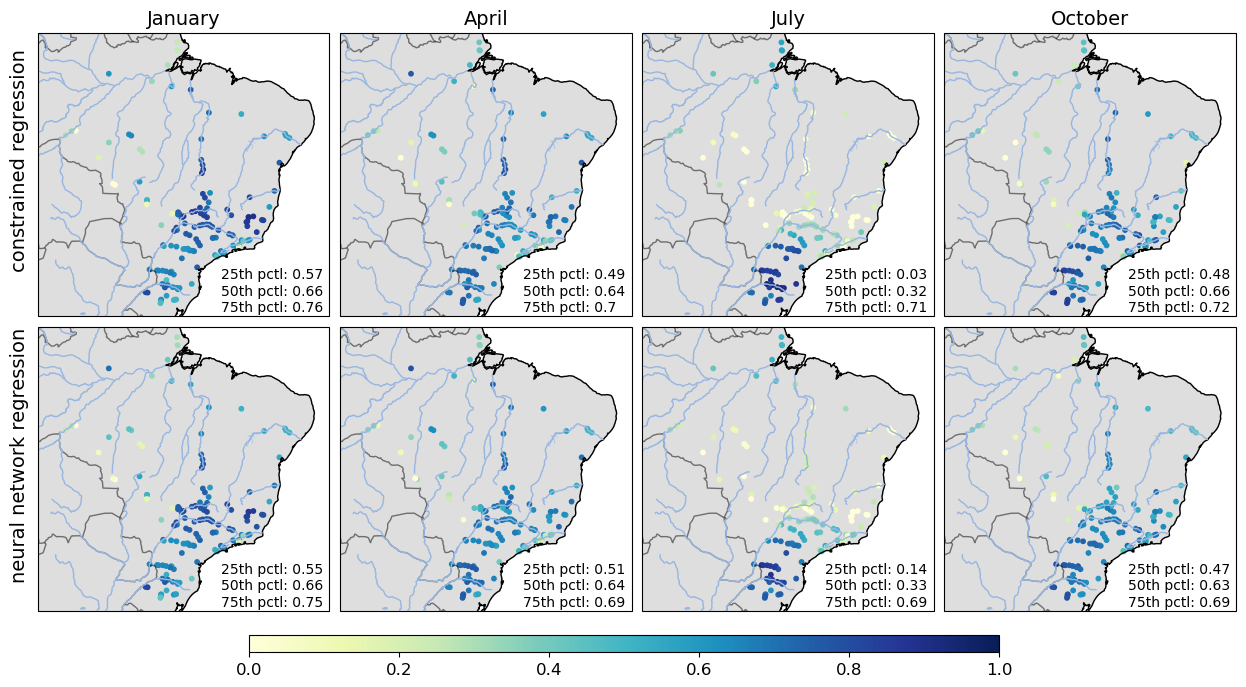

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12.5,6.8))
for i in range(2):
    for j in range(4):
        if i==0:
            R2_plot = df_R2_cv[[1,4,7,10][j]].to_numpy()
            R2_quartiles_plot = R2_quartiles[[1,4,7,10][j]].round(2)
        else:
            R2_plot = df_R2_cv_ann[[1,4,7,10][j]].to_numpy()
            R2_quartiles_plot = R2_quartiles_ann[[1,4,7,10][j]].round(2)
        axs[i,j].set_extent(lon_bounds+lat_bounds, crs=ccrs.PlateCarree())
        axs[i,j].add_feature(cfeature.LAND, color="lightgrey", alpha=0.75)
        axs[i,j].add_feature(cfeature.COASTLINE)
        axs[i,j].add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
        axs[i,j].add_feature(cfeature.LAKES, alpha=0.95)
        axs[i,j].add_feature(cfeature.RIVERS)
        if i == 0:
            axs[i,j].set_title(['January','April','July','October'][j], fontsize=14)
        cscatter = axs[i,j].scatter(x=basin_info_df['Lon'], y=basin_info_df['Lat'], c=R2_plot, cmap='YlGnBu', s=10, transform=ccrs.PlateCarree(), vmin=0, vmax=1)
        axs[i,j].text(-46, -26.5, '25th pctl: '+str(R2_quartiles_plot[0.25]), fontsize=10)
        axs[i,j].text(-46, -28.5, '50th pctl: '+str(R2_quartiles_plot[0.5]), fontsize=10)
        axs[i,j].text(-46, -30.5, '75th pctl: '+str(R2_quartiles_plot[0.75]), fontsize=10)

axs[0,0].text(-0.03, 0.55, 'constrained regression', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[0,0].transAxes, fontsize=14)
axs[1,0].text(-0.03, 0.55, 'neural network regression', va='bottom', ha='center',  rotation='vertical', rotation_mode='anchor', transform=axs[1,0].transAxes, fontsize=14)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.03, right=0.99, wspace=0.03, hspace=0.04)
cbar_ax = fig.add_axes([0.2, 0.039, 0.6, 0.025])
cbar = plt.colorbar(cscatter, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
fig.canvas.draw()